In [1]:
#imports
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.naive_bayes import BernoulliNB
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/kristin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Naive Baysian Sentiment Prediction Revisited

This is an assignment for my thinkful data science course - "naive_bayes_sentiment_prediction_revisitedv2."  The goal of the exercise is to iteratively improve the naive baysian model that classifies reviews as positive or negative, and to compare those models, answering three questions: 

* Do any of your classifiers seem to overfit?
* Which seem to perform the best? Why?
* Which features seemed to be most impactful to performance?

I'm defining performance as improvement in accuracy over baseline performance when predicting on any of 3 types of review sentence: imdb, amazon, or yelp. 

Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/naive_bayes_sentiment_prediction_revisitedv2.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/naive_bayes_sentiment_prediction_revisitedv2.ipynb) - with all the code exposed in an interactive notebook

My five models are: 

1. A model trained on the **imdb data only** and built with **hand-selected one-hot features** indicating presence or absence of a lemma in the review sentence. 
2. A model trained on the **imdb data only** and built with **algorithmically-chosen, one-hot features** indicating presence or absence of a lemma in the review sentence.  These features are chosen based on both high occurrence and high sentiment-splitting. I'll call this feature set B. 
3. Trained with **hand-chosen features** from **all 3 review types** and trained on all 3 types of review (imdb, amazon, and yelp). 
4. Trained with **algorithmically-chosen features** from **all 3 review types** and trained on all 3 types of review.
5. Same as the fourth model, but also including "review type" as a feature, where review type is either imdb or not (has to be a binary variable to use the bernouli distribution).   
6. Trained with all the features - hand-selected, algorithmically-chosen and the review type, and trained on all 3 types of review. 

To answer the questions posed: 

**Do any of your classifiers seem to overfit?**
No.  The leave one out showed some pretty tight distribution of accuracies across trials. 

**Which seem to perform the best? Why?**
The models with the hand-chosen features peformed the best.  This could be because the hand-chosen features were picked primarily from lemmas that appeared in a lot of the observations (high occurrence rate), while the algorithmic features were looking for lemmas that split sentiment best, but may not appear as frequently.  

**Which features seemed to be most impactful to performance?**
Judging from the above, the occurence rate of a lemma made that lemma more valuable as a feature.  

In [2]:
# Grab and process the raw data.

imdb_raw = pd.read_csv("imdb_labelled.txt", delimiter= '\t', header=None)
amazon_raw = pd.read_csv("amazon_cells_labelled.txt", delimiter= '\t', header=None)
yelp_raw = pd.read_csv("yelp_labelled.txt", delimiter= '\t', header=None)
imdb_raw.columns = amazon_raw.columns = yelp_raw.columns = ['sentence', 'sentiment']

imdb_raw["review_type"] = True
amazon_raw["review_type"] = False
yelp_raw["review_type"] = False

reviews_raw = pd.concat([imdb_raw, amazon_raw, yelp_raw], ignore_index=True)

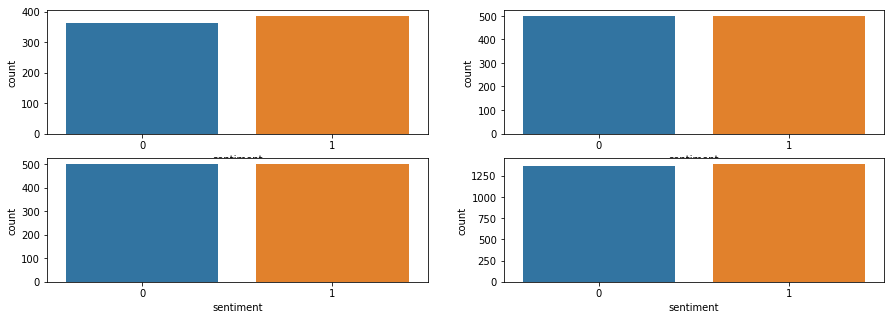

The dominant class rate for all reviews is  0.5043668122270742
That's the accuracy rate we'd get if we always guessed 'positive'


In [3]:
#peak at the distributions of the three datasets and the combined dataset. 
plt.figure(figsize=(15, 5))
plt.subplot(2,2,1)
sns.countplot(imdb_raw["sentiment"])
plt.subplot(2,2,2)
sns.countplot(amazon_raw["sentiment"])
plt.subplot(2,2,3)
sns.countplot(yelp_raw["sentiment"])
plt.subplot(2,2,4)
sns.countplot(reviews_raw["sentiment"])
plt.show()

#dominant class rate
dominant_class_rate = sum([x for x in reviews_raw.sentiment])/len(reviews_raw)
print("The dominant class rate for all reviews is ", dominant_class_rate)
print("That's the accuracy rate we'd get if we always guessed 'positive'")

There is no material class imbalance. Any accuracy over 50.4% is an improvement. 

In [4]:
#add a column of the lemmas in each sentence, and calculate the occurrence rate of each lemma

#some constants: 
lemmatizer = WordNetLemmatizer()
stops = stopwords.words("english")

#functions
def word_count(words, counts, exclusions):
    words

    for word in words:
        word = word.translate(str.maketrans('', '', string.punctuation))
        word = word.lower()
        
        if word not in exclusions:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

    return (counts)

def lemmatize_sentence(sentence):
    """
    uses the nltk.stem.WordNetLemmatizer to translate sentence words into lemmas
    """
    lemma_list = []
    words = sentence.split()
    for word in words:
        word = word.translate(str.maketrans('', '', string.punctuation))
        word = word.lower()
        word = lemmatizer.lemmatize(word)
        lemma_list.append(word)
    return np.array(lemma_list)

def lemmatize_sentences(df):
    """
    Uses the function "lemmatize sentence" to create a column in the given dataframe
    containing a list of the lemmas in the sentence. 
    
    Also uses the function "word_count" to return a tuple for each lemma, containing 
    the lemma and the occurrence count of that lemma across all sentences in the dataframe,
    stop words removed.
    """
    counts = dict()
    counts.clear()
    df["lemmas"] = "empty"

    for index, row in df.iterrows():
        lems = lemmatize_sentence(str(df.loc[index, "sentence"]))
        df.at[index, "lemmas"] = lems
        counts = word_count(lems, counts, stops)
    return counts

#these statements add a list of lemmas as a column to each dataframe and return a count of each lemma
#across all sentences in the dataframe
imdb_lemmas = sorted(lemmatize_sentences(imdb_raw).items(),  key=lambda x: x[1], reverse = True)
amazon_lemmas = sorted(lemmatize_sentences(amazon_raw).items(),  key=lambda x: x[1], reverse = True)
yelp_lemmas = sorted(lemmatize_sentences(yelp_raw).items(),  key=lambda x: x[1], reverse = True)
all_lemmas = sorted(lemmatize_sentences(reviews_raw).items(),  key=lambda x: x[1], reverse = True)


In [5]:
#create separate training & validation dataframes for each model - to avoid confusion and allow for different feature lists
# imdb_1 = imdb_raw.copy()
# review_1_test = reviews_raw.copy()
# imdb_2 = imdb_raw.copy()
# review_2_test = reviews_raw.copy()
# reviews_3 = reviews_raw.copy()
# reviews_4 = reviews_raw.copy()
# reviews_5 = reviews_raw.copy()

In [6]:
#define hand-selected features for model 1 and model 3
#feature set A is hand-selected lemmas.  
#I've select 10 from the list of highest occurring lemmas in the imdb dataset
#based only on my subjective assessment of lemmas that indicate a positive or negative sentiment
MODEL_1_FEATURES = ["bad", "good", "like", "great", "well", "best", "love", "funny", "better", "wonderful"]
MODEL_3_FEATURES = ["good", "great", "like", "bad", "well", "best", "love", "better", "nice", "recommend"]

In [7]:
#define algorithmically-selected features for models 2, 4, and 5

def split_rate(df, lemma_col, lemma, outcome):
    hot = [lemma in lemmas for lemmas in df[lemma_col]]
    n = sum(hot)
    positive = len(df[hot & df[outcome]]) / n
    negative = 1-positive
    return max(positive, negative)

def get_best_splitters(df, lemmas, lemma_col, outcome, top_x):
    split_rates = pd.DataFrame([(lemma, split_rate(df, lemma_col, lemma, "sentiment")) for lemma in lemmas])
    split_rates.columns = ["lemma", "split_rate"]
    split_rates = split_rates.sort_values(by="split_rate", ascending=False).head(top_x)
    return split_rates["lemma"].values

def has_lemma(word_list, lemma): 
    return (lemma in word_list)

#model 2: lemmas from the imdb dataset only
top_imdb_lemmas = [x[0] for x in imdb_lemmas[:200]]  #most frequently occurring lemmas
MODEL_2_FEATURES = get_best_splitters(imdb_raw, top_imdb_lemmas, "lemmas", "sentiment", 20)   

#model 4: lemmas from all datasets
top_all_lemmas = [x[0] for x in imdb_lemmas[:200]]  #most frequently occurring lemmas
MODEL_4_FEATURES = get_best_splitters(reviews_raw, top_imdb_lemmas, "lemmas", "sentiment", 20)

#model 5: same as model 4 + review_type
MODEL_5_FEATURES = list(MODEL_4_FEATURES)
MODEL_5_FEATURES.append("review_type")

#model 6: all the features!

MODEL_6_FEATURES = set(MODEL_1_FEATURES).union(set(MODEL_2_FEATURES), set(MODEL_3_FEATURES), 
                                               set(MODEL_5_FEATURES))

In [8]:
print(MODEL_1_FEATURES)
print(MODEL_2_FEATURES)
print(MODEL_3_FEATURES)
print(MODEL_4_FEATURES)
print(MODEL_5_FEATURES)
print(MODEL_6_FEATURES)


['bad', 'good', 'like', 'great', 'well', 'best', 'love', 'funny', 'better', 'wonderful']
['awful' 'interesting' 'suck' 'worst' 'role' 'wasted' 'wonderful' 'waste'
 'stupid' 'nothing' 'bad' 'played' 'loved' 'liked' 'action' 'im' 'word'
 'girl' 'hour' 'place']
['good', 'great', 'like', 'bad', 'well', 'best', 'love', 'better', 'nice', 'recommend']
['interesting' 'wasted' 'role' 'worst' 'waste' 'wonderful' 'awful' 'loved'
 'great' 'bad' 'excellent' 'stupid' 'terrible' 'nothing' 'played' 'suck'
 'family' 'action' 'beautiful' 'girl']
['interesting', 'wasted', 'role', 'worst', 'waste', 'wonderful', 'awful', 'loved', 'great', 'bad', 'excellent', 'stupid', 'terrible', 'nothing', 'played', 'suck', 'family', 'action', 'beautiful', 'girl', 'review_type']
{'review_type', 'funny', 'well', 'action', 'worst', 'love', 'interesting', 'played', 'word', 'bad', 'wonderful', 'liked', 'hour', 'terrible', 'girl', 'loved', 'suck', 'place', 'stupid', 'family', 'recommend', 'beautiful', 'im', 'better', 'waste', 

In [9]:
#add the feature columns to each datasets

def kw_feature_creation(df, words): 
    for index, row in df.iterrows():
        for word in words: 
            df.loc[index, str(word)] = [(word in df.loc[index, "lemmas"])] 
            
#imdb_raw needs just model 1 & 2 features
model1_model2_features = set(MODEL_1_FEATURES).union(set(MODEL_2_FEATURES))
kw_feature_creation(imdb_raw, model1_model2_features)

#reviews_raw needs all the features - note that review_type is already a column
all_features = set(MODEL_1_FEATURES).union(set(MODEL_2_FEATURES), set(MODEL_3_FEATURES), set(MODEL_4_FEATURES))
kw_feature_creation(reviews_raw, all_features)

In [10]:
#train the models and evaluate on the training data

def evaluate_model(target, y_pred, test_name):
    print(test_name, "error rate is ", (target != y_pred).sum() / target.shape[0])

#Model 1: A model trained on the imdb data only and built with hand-selected one-hot features 
#indicating presence or absence of a lemma in the review sentence.
bnb1 = BernoulliNB()
bnb1.fit(imdb_raw[MODEL_1_FEATURES], imdb_raw['sentiment'])
predictions1 = bnb1.predict(imdb_raw[MODEL_1_FEATURES])
evaluate_model(imdb_raw['sentiment'], predictions1, "model 1 on training data")

#Model 2: A model trained on the imdb data only and built with algorithmically-chosen, one-hot 
#features indicating presence or absence of a lemma in the review sentence. These features are 
#chosen based on both high occurrence and high sentiment-splitting. 
bnb2 = BernoulliNB()
bnb2.fit(imdb_raw[MODEL_2_FEATURES], imdb_raw['sentiment'])
predictions2 = bnb2.predict(imdb_raw[MODEL_2_FEATURES])
evaluate_model(imdb_raw['sentiment'], predictions2, "model 2 on training data")

#Model 3: Trained with hand-chosen features from all 3 review types and trained on all 3 types 
#of review (imdb, amazon, and yelp).
bnb3 = BernoulliNB()
bnb3.fit(reviews_raw[MODEL_3_FEATURES], reviews_raw['sentiment'])
predictions3 = bnb3.predict(reviews_raw[MODEL_3_FEATURES])
evaluate_model(reviews_raw['sentiment'], predictions3, "model 3 on training data")

#Model 4: Trained with algorithmically-chosen features from all 3 review types and trained on all 
#3 types of review.
bnb4 = BernoulliNB()
bnb4.fit(reviews_raw[MODEL_4_FEATURES], reviews_raw['sentiment'])
predictions4 = bnb4.predict(reviews_raw[MODEL_4_FEATURES])
evaluate_model(reviews_raw['sentiment'], predictions4, "model 4 on training data")

#Model 5. Same as the fourth model, but also including "review type" as a feature.  
bnb5 = BernoulliNB()
bnb5.fit(reviews_raw[MODEL_5_FEATURES], reviews_raw['sentiment'])
predictions5 = bnb5.predict(reviews_raw[MODEL_5_FEATURES])
evaluate_model(reviews_raw['sentiment'], predictions5, "model 5 on training data")

#Model 6. All the features!  
bnb6 = BernoulliNB()
bnb6.fit(reviews_raw[MODEL_6_FEATURES], reviews_raw['sentiment'])
predictions6 = bnb6.predict(reviews_raw[MODEL_6_FEATURES])
evaluate_model(reviews_raw['sentiment'], predictions6, "model 6 on training data")

model 1 on training data error rate is  0.39572192513368987
model 2 on training data error rate is  0.3422459893048128
model 3 on training data error rate is  0.3511644832605531
model 4 on training data error rate is  0.3948326055312955
model 5 on training data error rate is  0.37954876273653565
model 6 on training data error rate is  0.302037845705968


When testing on the training data...
* the hand-picked features (models 1 & 3) outperformed the algorithmically generated features
* and the review_type feature addition (model 5 vs. model 4) did not impact performance

In [11]:
#test the models with holdout data

from sklearn.model_selection import cross_val_score

# #for models 1 & 2, we will test the model on all of the data (really should only test on non-training imdb and other types)
# test_predictions1 = bnb1.predict(reviews_raw[MODEL_1_FEATURES])
# evaluate_model(reviews_raw['sentiment'], test_predictions1, "model 1 on test data")

# test_predictions2 = bnb2.predict(reviews_raw[MODEL_2_FEATURES])
# evaluate_model(reviews_raw['sentiment'], test_predictions2, "model 2 on test data")

#for models 3-5, we will use leave-one-out to evaluate
kfold_accuracies3 = cross_val_score(bnb3, reviews_raw[MODEL_3_FEATURES], reviews_raw['sentiment'], cv=10)
print("model 3 accuracies: ", kfold_accuracies3)
print("model 3 ave acc: ", sum(kfold_accuracies3) / len(kfold_accuracies3))
print("\n")

kfold_accuracies4 = cross_val_score(bnb4, reviews_raw[MODEL_4_FEATURES], reviews_raw['sentiment'], cv=10)
print("model 4 accuracies: ", kfold_accuracies4)
print("model 4 ave acc: ", sum(kfold_accuracies4) / len(kfold_accuracies4))
print("\n")

kfold_accuracies5 = cross_val_score(bnb5, reviews_raw[MODEL_5_FEATURES], reviews_raw['sentiment'], cv=10)
print("model 5 accuracies: ", kfold_accuracies5)
print("model 5 ave acc: ", sum(kfold_accuracies5) / len(kfold_accuracies5))

kfold_accuracies6 = cross_val_score(bnb6, reviews_raw[MODEL_6_FEATURES], reviews_raw['sentiment'], cv=10)
print("model 6 accuracies: ", kfold_accuracies6)
print("model 6 ave acc: ", sum(kfold_accuracies6) / len(kfold_accuracies6))

model 3 accuracies:  [0.58695652 0.60144928 0.60727273 0.74545455 0.68       0.70545455
 0.6350365  0.64963504 0.62773723 0.64963504]
model 3 ave acc:  0.6488631410903706


model 4 accuracies:  [0.60144928 0.60869565 0.61454545 0.65454545 0.61090909 0.58545455
 0.59854015 0.59489051 0.58394161 0.59124088]
model 4 ave acc:  0.6044212611676908


model 5 accuracies:  [0.63768116 0.64130435 0.61454545 0.65454545 0.61090909 0.58545455
 0.59854015 0.59489051 0.58394161 0.59124088]
model 5 ave acc:  0.6113053191387052
model 6 accuracies:  [0.69565217 0.69202899 0.69090909 0.77818182 0.71272727 0.72363636
 0.66423358 0.68613139 0.66423358 0.66058394]
model 6 ave acc:  0.6968318186626661


The hand-picked features outperform the algorithmically selected features.  
Review Type as a feature has no impact - which is suprising.  

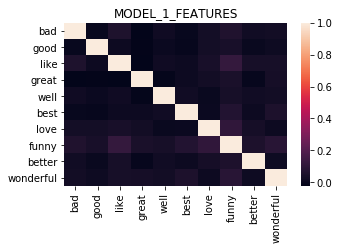

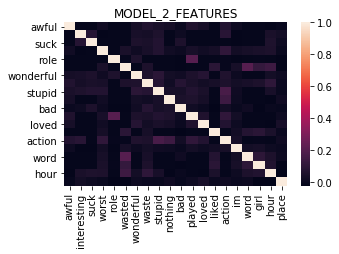

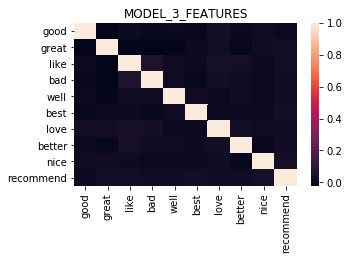

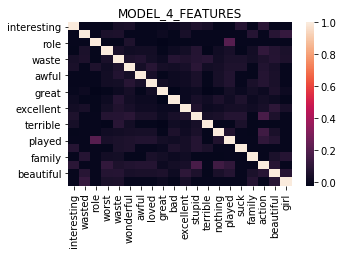

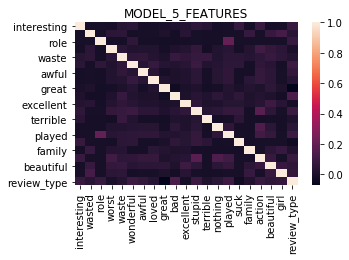

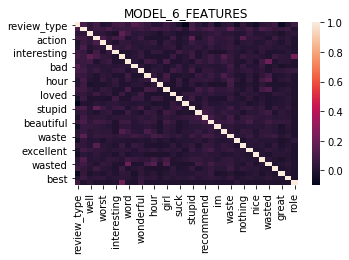

In [12]:
#test for correlation between feature pairs 
#looks pretty good (i.e. low pair-wise correlation for all feature sets)
feature_sets = [MODEL_1_FEATURES, MODEL_2_FEATURES, MODEL_3_FEATURES, MODEL_4_FEATURES, 
                MODEL_5_FEATURES, MODEL_6_FEATURES]
titles = ["MODEL_1_FEATURES", "MODEL_2_FEATURES", "MODEL_3_FEATURES", "MODEL_4_FEATURES", 
                "MODEL_5_FEATURES", "MODEL_6_FEATURES"]
i=0
for feature_set in feature_sets:
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    corrs = reviews_raw[feature_set].corr()
    sns.heatmap(corrs)
    ax.set_title(titles[i])
    i+=1
    plt.show()


In [13]:
Might be good to remove one each of the few red pairs in models 4-6.  

SyntaxError: invalid syntax (<ipython-input-13-c6c9881444a9>, line 1)

In [ ]:
#different error types - confusion matrix
print("Model 3 confusion matrix...")
print(sklearn.metrics.confusion_matrix(reviews_raw["sentiment"],  predictions3))

print("Model 4 confusion matrix...")
print(sklearn.metrics.confusion_matrix(reviews_raw["sentiment"],  predictions4))

print("Model 5 confusion matrix...")
print(sklearn.metrics.confusion_matrix(reviews_raw["sentiment"],  predictions5))

print("Model 6 confusion matrix...")
print(sklearn.metrics.confusion_matrix(reviews_raw["sentiment"],  predictions6))

All the models are guessing negative much more often than positive.   

In [ ]:
#some functions I'm not using any more
            
def test_any_feature_present(df, cols):
    
    hot = 0
    not_hot = 0

    for index, row in df.iterrows():
        if df.loc[index, cols].values.any():
            hot += 1
        else: 
            not_hot += 1

    print("hit rate is ", hot / (hot + not_hot))
    
def train_and_predict(features, target):
    bnb = BernoulliNB()
    bnb.fit(features, target)
    return bnb.predict(features)

